# Evaluating SEIDR Model
In this notebook, we use the SEIDR model to try to estimate high- and low-risk health regions.
- results for 8 biggest HR's in Canada
- Changing the prediction period

In [63]:
import sqlite3 as sql
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.dates as mdates
from datetime import date, timedelta
import lmfit
#from seirsplus.models import *
from scipy.integrate import odeint

In [40]:
def get_HR_name(HR_UID):
    conn = sql.connect('../data/hubs.db')
    cursor = conn.cursor()
    
    cursor.execute('SELECT ENGNAME FROM HR WHERE HR_UID = ' + str(HR_UID))
    rows = cursor.fetchall()
    if len(rows) == 0:
        print("No HR with that UID")
        return None
    
    return rows[0][0]

# Use to get data from the Covid19 table. 
#    columns : a string of column names from the Covid19 table, must be separated by ', '. Eg 'dates, cases'
#    HR_UID : a four digit HR ID, as an int or string. Ottawa is 3551
def get_HR_data(columns, HR_UID):
    conn = sql.connect('../data/hubs.db')
    cursor = conn.cursor()

    cursor.execute('SELECT ' + columns + ' FROM Covid19 WHERE HR_UID = ' + str(HR_UID))
    results = pd.DataFrame(cursor.fetchall())
    results.columns = columns.split(', ')
    #print(results[:5])
    cursor.close()
    conn.close()
    
    return results

# Use to get all the health indicators for a health region from the Health_Indicators_ODHF table as a dictionary. 
#    HR_UID : a four digit HR ID, as an int or string. Ottawa is 3551
def get_HR_dict(HR_UID):
    conn = sql.connect('../data/hubs.db')
    cursor = conn.cursor()

    cursor.execute('SELECT * FROM Health_Indicators_ODHF WHERE HR_UID == ' + str(HR_UID))
    tuples = cursor.fetchall()
    if len(tuples) == 0:
        print("No HR with that UID")
        return None

    results = [tuples[0][y] for y in range(len(tuples[0]) - 1)]
    keys = [cursor.description[y][0] for y in range(len(cursor.description) - 1)]

    hr_dict = {}
    for key in zip(keys,results):
        hr_dict[key[0]] = key[1]

    return hr_dict

# Plot the data returned by get_HR_data. 
#    df : a dataframe of the from returned by get_HR_data
#    column : name of column (or columns) to plot. If None, then plots all columns. Should be a string of the same form as in get_HR_data
#    hr_name : name of the HR plotted, as a string. Prints the name of the HR in the title.
def plot_frame(df, column = None, hr_name = None):
    months = mdates.MonthLocator()
    days = mdates.DayLocator()
    years_fmt = mdates.DateFormatter("%Y-%m-%d") # Sets the output format for dates on axis

    # Set up the plot
    fig, ax = plt.subplots(figsize = (19,10))
    dates = df['report_date'].apply(lambda x : np.datetime64(x))
    if column == None:
        column = list(df.columns[1:])
    else:
        column = column.split(', ')
    for col in column:
        ax.scatter(dates, df[col])

    # Set the axis
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(years_fmt)
    ax.xaxis.set_minor_locator(days)

    # Set the axis ranges
    datemin = dates[0]
    datemax = dates[len(dates) - 1]
    ax.set_xlim(datemin, datemax)

    # More axis stuff
    ax.format_xdata = mdates.DateFormatter("%m-%d")
    ax.grid(True)
    fig.autofmt_xdate()
    
    plt.title("Data about " + ", ".join(column) + " by day" + ("" if hr_name == None else ' in ' + hr_name), fontdict = {'fontsize': 20} )
    plt.legend(column, fontsize = 15)

    return fig, ax, plt

def deriv(y, t, beta, delta, rho, alpha, gamma, N):
    S, E, I, D, R = y # y wraps up all the compartments
    
    
    dSdt = - S * I * beta(t) / N
    dEdt = S * I * beta(t) / N - delta * E
    dIdt = delta * E - rho * alpha * I - gamma * (1 - alpha) * I
    dDdt = rho * alpha * I
    dRdt = gamma * (1 - alpha) * I
    
    return dSdt, dEdt, dIdt, dDdt, dRdt

def logistic_R_0(t, R_0_start, k, x0, R_0_end):
    return (R_0_start - R_0_end) / (1 + np.exp(-k*(-t+x0))) + R_0_end

def Model(days, N, R_0_start, k, x0, R_0_end, delta, rho, gamma, alpha):
    
    def beta(t):
        return logistic_R_0(t, R_0_start, k, x0, R_0_end) * gamma
    
    y0 = N - 1.0, 1.0, 0.0, 0.0, 0.0 # Initial population; just one exposed person
    
    t = np.linspace(0, days - 1, int(days))
    ret = odeint(deriv, y0, t, args=(beta, delta, rho, alpha, gamma, N))
    S, E, I, D, R = ret.T
    
    # this is R_0 throughout for plotting
    R_0_over_time = [beta(i) / gamma for i in range(len(t))]
    beta_over_time = [beta(i) for i in range(len(t))]
    
    return t, S, E, I, D, R, R_0_over_time, beta_over_time

# def Model(days, N, model):
#     R_0_start, k, x0, R_0_end = model.best_values.values()
#     return Model(days, N, R_0_start, k, x0, R_0_end)

def plotting(t, S, E, I, D, R, R_0_over_time, beta_over_time, x_ticks = None):
    f,ax = plt.subplots(1,1,figsize=(15,4))
    ax.title.set_text("SEIDR Model")
    
####!=
    if x_ticks is not None:
        months = mdates.MonthLocator()
        days = mdates.DayLocator()
        years_fmt = mdates.DateFormatter("%Y-%m-%d") # Sets the output format for dates on axis

        # Set up the plot
        dates = x_ticks.apply(lambda x : np.datetime64(x))

        # Set the axis
        ax.xaxis.set_major_locator(months)
        ax.xaxis.set_major_formatter(years_fmt)
        ax.xaxis.set_minor_locator(days)

        # Set the axis ranges
        datemin = dates[0]
        datemax = datemin + timedelta(days=len(t) - 1)
        ax.set_xlim(datemin, datemax)

        ax.format_xdata = mdates.DateFormatter("%m-%d")
        #ax.grid(True)
        f.autofmt_xdate()
        
        t = pd.date_range(start = datemin, end = datemax)
####
    def annihilate_small_values(compartment):
        return [compartment[i] if compartment[i] >=1 else 1 for i in range(len(compartment))]

    ax.plot(t, annihilate_small_values(S), 'b', alpha = 0.7, linewidth = 2, label='Susceptible')
    ax.plot(t, annihilate_small_values(E), 'y', alpha = 0.7, linewidth = 2, label='Exposed')
    ax.plot(t, annihilate_small_values(I), 'r', alpha = 0.7, linewidth = 2, label='Infected')
    ax.plot(t, annihilate_small_values(D), 'k', alpha = 0.7, linewidth = 2, label='Dead')
    ax.plot(t, annihilate_small_values(R), 'g', alpha = 0.7, linewidth = 2, label='Recovered')
    ax.set_yscale('log')

    legend = ax.legend()
    ax.grid(b = False, which = 'minor',c='w', lw = 2, ls = '-')

    
    
    
    for spine in ('top', 'right', 'bottom', 'left'):
            ax.spines[spine].set_visible(False)


    plt.show()

    f = plt.figure(figsize = (15,4))
    # Plot of R_0 over time
    ax1 = f.add_subplot(131)
    ax1.plot(t, R_0_over_time, alpha = 0.7, linewidth=2, label='R_0')
    ax1.title.set_text('Daily R_0 value')
    legend = ax1.legend()
    for spine in ('top','right','bottom','left'):
        ax1.spines[spine].set_visible(False)
    
    # Plot of total infected death rate. Calculated as total deaths divided by everyone who's been infected up to that point.
    # Denominator is calculated as delta * sum(E[:t]), because that is all the people added to the I compartment.
    ax2 = f.add_subplot(132)
    total_CFR = [0] + [100 * D[i] / sum(delta * E[:i]) if sum(delta * E[:i]) > 0 else 0 for i in range(1, len(t))]
    ax2.plot(t, total_CFR, alpha = 0.7, linewidth = 2, label = 'Death Rate among Infected')
    legend = ax2.legend()
    ax2.title.set_text("Death Rate %")
    for spine in ('top', 'right', 'bottom', 'left'):
            ax2.spines[spine].set_visible(False)

    # Plot of deaths per day.
    ax3 = f.add_subplot(133)
    newDs = [0] + [D[i] - D[i - 1] for i in range(1, len(t))]
    ax3.plot(t, newDs, alpha = 0.7, linewidth=2, label="Daily Deaths")
    ax3.title.set_text("Deaths Per Day")
    for spine in ('top', 'right', 'bottom', 'left'):
            ax3.spines[spine].set_visible(False)
        
    f.autofmt_xdate()
    plt.show()
    
    
def fitter(x, days, N, R_0_start, k, x0, R_0_end, delta, rho, gamma, alpha):
    ret = Model(days, N, R_0_start, k, x0, R_0_end, delta, rho, gamma, alpha)
    
    return ret[4][x] # return the xth value of Deaths, which is 4 in the return list of Model

def fit_SEIDR_model(HR_UID, days_to_ignore = None, delta = 1 / 5.0, rho = 1 / 12.0, gamma = 1 / 19.2, alpha = None):

    hr_dict = get_HR_dict(HR_UID) 
    df = get_HR_data('report_date, cumulative_deaths, cumulative_cases', HR_UID) 

    deaths = np.array(df["cumulative_deaths"])
    if days_to_ignore != None:
        deaths = deaths[:-days_to_ignore]
    cases = np.array(df["cumulative_cases"])
    days = len(deaths)
    x_dat = np.linspace(0, days - 1, days, dtype=int)
    
    N = hr_dict["Population_rate"]

    if alpha == None:
        alpha = deaths[-1] / cases[-(1 + int(np.floor(1 / gamma)))] # death rate

    
    mod = lmfit.Model(fitter)
        
    mod.set_param_hint("R_0_start", value = 5.7, min = 1, max = 15, vary = True)
    mod.set_param_hint("k", value = 2, min = .001, max = 5, vary = True)
    mod.set_param_hint("x0", value = 60, min = 10, max = 150, vary = True)
    mod.set_param_hint("R_0_end", value = 1.1, min = 0.01, max = 2.5, vary = True)
    mod.set_param_hint("days",value = days, vary = False)
    mod.set_param_hint("N", value = N, vary = False)
    mod.set_param_hint("delta", value = delta, vary = False)
    mod.set_param_hint("rho", value = rho, vary = False)
    mod.set_param_hint("gamma", value = gamma, vary = False)
    mod.set_param_hint("alpha", value = alpha, vary = False)
    
    
    params = mod.make_params()
    fit_method = 'leastsq'
        
    #result = mod.fit(deaths, params, method = fit_method, x = x_dat, days = days, N = N)
    result = mod.fit(deaths, params, method = fit_method, x = x_dat)
    return result

def predict_risk(HR_UID, result, model):
    days, N, R_0_start, k, x0, R_0_end, delta, rho, gamma, alpha = result.best_values.values()
    
    df = get_HR_data('report_date, cumulative_deaths, cumulative_cases', HR_UID) 
    deaths = np.array(df["cumulative_deaths"])
    cases = np.array(df['cumulative_cases'])

    print("Interested in HR: " + str(HR_UID) + " " + get_HR_name(HR_UID))
    print("According to the model, the total number of cases is " + str(np.floor(sum(delta * model[2]))) + ', compared to ' + str(cases[-1]) + ' as reported in the covid data')
    print()
    print('True deaths: ' + str(deaths[-1]))
    print('Predicted deaths: ' + str(model[4][days+7]))
    if deaths[-1] > model[4][days+7]:
        print("Thus, health region " + str(HR_UID) + " is a high-risk HR")
    else:
        print("Thus, health region " + str(HR_UID) + " is a low-risk HR")
    

# Running the model on several HR's

In [30]:
HRs = [3551, 3595, 2406, 4834, 4832, 1204, 4601]
HR_names = ['Ottawa', 'Toronto', 'Montreal', 'Edmonton', 'Calgary', 'Halifax', 'Winnepeg']

In [27]:
for hr in HRs[6:]:
    res_dict[hr] = fit_SEIDR_model(hr, 7)

In [31]:
res_dict

{3551: <lmfit.model.ModelResult at 0x7ff2904d0bd0>,
 3595: <lmfit.model.ModelResult at 0x7ff2904cb350>,
 2406: <lmfit.model.ModelResult at 0x7ff290526450>,
 4834: <lmfit.model.ModelResult at 0x7ff290447990>,
 4832: <lmfit.model.ModelResult at 0x7ff29054ff50>,
 1204: <lmfit.model.ModelResult at 0x7ff28f7d3450>,
 4601: <lmfit.model.ModelResult at 0x7ff28f7cc210>}

Interested in HR: 3551 City of Ottawa Health Unit


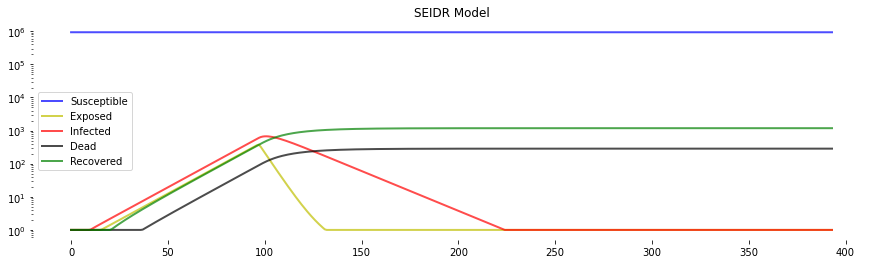

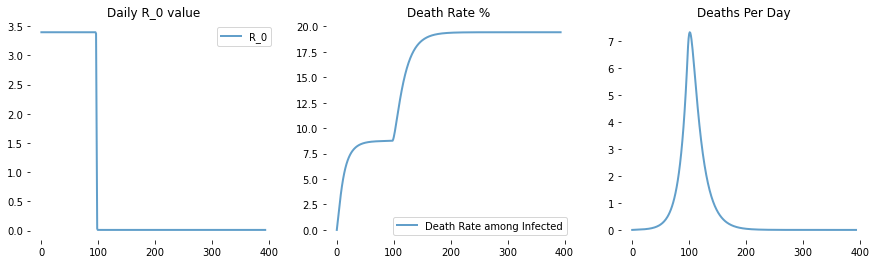

Interested in HR: 3551 City of Ottawa Health Unit
According to the model, the total number of cases is 1466.0, compared to 2061 as reported in the covid data

True deaths: 261
Predicted deaths: 273.76719723716917
Thus, health region 3551 is a low-risk HR


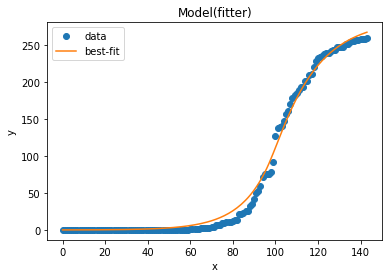

In [64]:
hr = HRs[0]
print("Interested in HR: " + str(hr) + ' ' + get_HR_name(hr))
res = res_dict[hr]
days, N, R_0_start, k, x0, R_0_end, delta, rho, gamma, alpha = res.best_values.values()
model = Model(days + 250, N, R_0_start, k, x0, R_0_end, delta, rho, gamma, alpha)
t, S, E, I, D, R, R_0_over_time, beta_over_time = model
plotting(*model)
res.plot_fit()
predict_risk(hr, res, model)

# Predictions at different times
We also consider running the model on different subsets of the data, and comparing how they predict the future. If the prediction with newer data is worse than that with older data, then we can conclude that the HR is performing less well than is was.

In [50]:
hr = 3551
res_new = fit_SEIDR_model(hr)
res_old = fit_SEIDR_model(hr, 30)

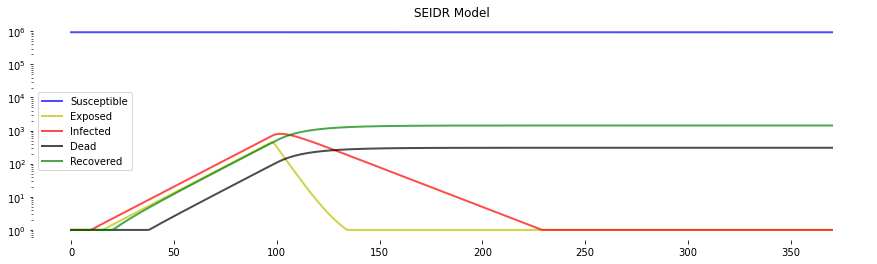

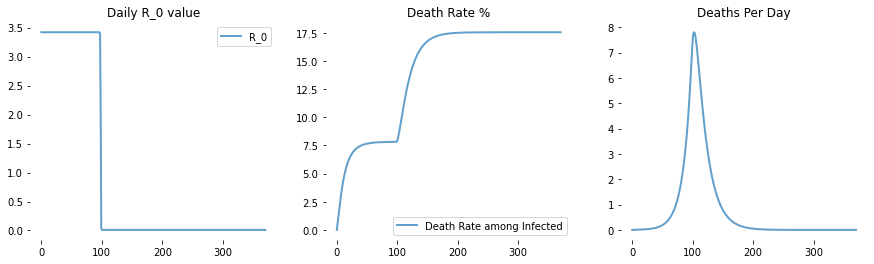

Predicted deaths next month: 301.5221723733353


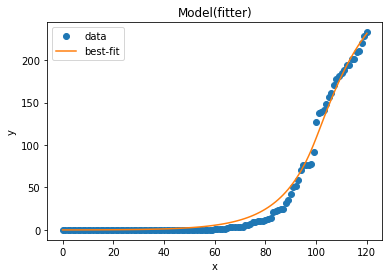

In [58]:
res = res_old
days, N, R_0_start, k, x0, R_0_end, delta, rho, gamma, alpha = res.best_values.values()
model = Model(days + 250, N, R_0_start, k, x0, R_0_end, delta, rho, gamma, alpha)
t, S, E, I, D, R, R_0_over_time, beta_over_time = model
plotting(*model)
res.plot_fit()
print('Predicted deaths next month: ' + str(model[4][days+67]))

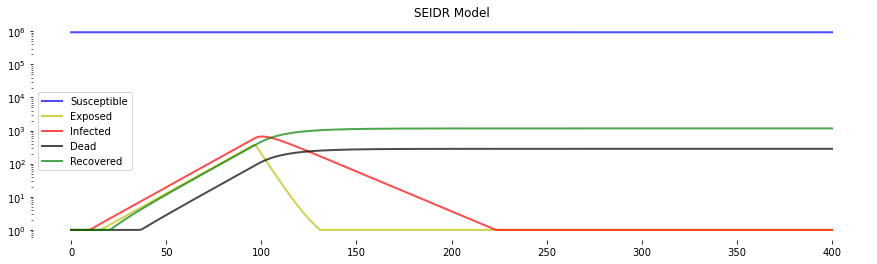

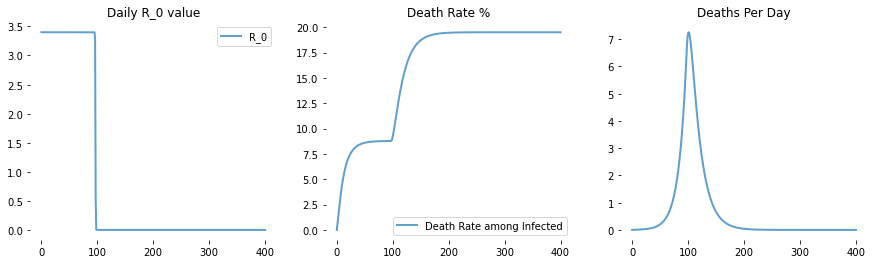

Predicted deaths by next month: 280.27566136138074


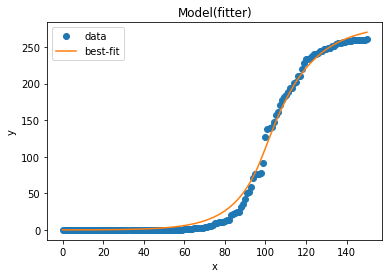

In [59]:
res = res_new
days, N, R_0_start, k, x0, R_0_end, delta, rho, gamma, alpha = res.best_values.values()
model = Model(days + 250, N, R_0_start, k, x0, R_0_end, delta, rho, gamma, alpha)
t, S, E, I, D, R, R_0_over_time, beta_over_time = model
plotting(*model)
res.plot_fit()
print('Predicted deaths by next month: ' + str(model[4][days+37]))


TODO:
- fit the epidemiological parameters as well
- add in cases
- look at model per 100000, normalization
- Group together similar health regions; perhaps into those A - H HR groups?
- Fitting transmission rate: McMaster is modeling transmission rate using a power law using mobility data
- Markov model that adds mobility to compartmental, just get mobility into the model